# Notebook 2: Tree-Based Ensembles

In this notebook, we test tree-based algorithms using the original train/valid/test split. When possible, we try to leave the settings as default, in some cases we tweak the settings so that similar models have similar settings (e.g. sklearn/XGBoost/LightGBM random forests). 

These benchmarks are not definitive, hyperparameter tweaking and feature engineering could cause different models to perform better/worse, these are just baselines so we can narrow our searches.

In [1]:
# Global variables for testing changes to this notebook quickly
RANDOM_SEED = 0
NUM_FOLDS = 12

In [2]:
import numpy as np
import pandas as pd
import time
import os
import pyarrow
import gc

# Model evaluation
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Models
from sklearn.utils.extmath import softmax
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


# Plotting
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [3]:
def get_data():
    try:
        #
        original = pd.read_feather('../data/original.feather')
    except:
        # Get Original Data
        original = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz', header = None)

        # Fix columns
        original.columns = ['Elevation', 'Aspect', 'Slope',
               'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
               'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
               'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
               'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
               'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
               'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
               'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
               'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
               'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
               'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
               'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
               'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
               'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
               'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40',
               'Cover_Type']

        for col, dtype in original.dtypes.iteritems():
            if dtype.name.startswith('int'):
                original[col] = pd.to_numeric(original[col], downcast ='integer')
            elif dtype.name.startswith('float'):
                original[col] = pd.to_numeric(original[col], downcast ='float')
        
        if not os.path.isdir('../data'):
            os.mkdir('../data')
        original.to_feather('../data/original.feather')
    return original

In [4]:
%%time
original = get_data()

# Get feature columns
features = [x for x in original.columns if x not in ['Id','Cover_Type']]
wilderness_cols = [x for x in features if x.startswith('Wild')]
soil_cols = [x for x in features if x.startswith('Soil')]
binary_cols = [x for x in features if x.startswith('Soil') or x in wilderness_cols]
numerical_cols = [x for x in features if x not in binary_cols]

# Encoder
old_encoder = LabelEncoder()
original["Cover_Type"] = old_encoder.fit_transform(original["Cover_Type"])

# Data structures for summary scores
metrics = list()

Wall time: 54 ms


# Scoring Function

In [5]:
def train_original(sklearn_model, plot = True):
    
    # Original Training/Test Split
    X_temp = original[features].iloc[:15119]
    X_test = original[features].iloc[15119:]
    y_temp = original['Cover_Type'].iloc[:15119]
    y_test = original['Cover_Type'].iloc[15119:]
    
    # Store the out-of-fold predictions
    test_preds = np.zeros((X_test.shape[0],7))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(X_temp,y_temp)):
       
        # Training and Validation Sets
        X_train = X_temp.iloc[train_idx]
        X_valid = X_temp.iloc[valid_idx]
        y_train = y_temp.iloc[train_idx]
        y_valid = y_temp.iloc[valid_idx]
        
        # Create model
        start = time.time()
        model = clone(sklearn_model)
        model.fit(X_train, y_train)

        # validation and test predictions
        valid_preds = np.ravel(model.predict(X_valid))
        test_preds += model.predict_proba(X_test)
        
        # fold auc score
        fold_acc = accuracy_score(y_valid, valid_preds)
        end = time.time()
        print(f'Fold {fold} Accuracy: {round(fold_acc, 5)} in {round(end-start,2)}s.')
        scores[fold] = fold_acc
        times[fold] = end-start
        time.sleep(0.5)
    
    test_preds = np.argmax(test_preds, axis = 1)
    holdout = accuracy_score(y_test, test_preds)
    print("\nAverage CV Accuracy:", round(scores.mean(), 5))
    print("Worst CV Accuracy:", round(scores.min(), 5))
    print('Holdout Accuracy:', round(holdout, 5))
    print(f'Training Time: {round(times.sum(), 2)}s\n')
    
    if plot:
        # Plot confusion matrix
        fig, ax = plt.subplots(figsize = (8,6))
        cm = confusion_matrix(y_test, test_preds, normalize = 'true')
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax = ax)
        plt.title("Confusion Matrix (% of Actual Labels)", fontsize=16)
        plt.xlabel("Predicted Labels", fontsize=14)
        plt.ylabel("Actual Labels", fontsize=14)
        plt.show()
    
    return scores.mean(), test_preds, holdout

# Scikit-Learn Models

We test the following models from the scikit-learn library:

1. AdaBoost
2. ExtraTrees
3. Bagging
4. RandomForest
5. GradientBoosting
6. HistGradientBoosting

## 1. AdaBoostClassifier

In [6]:
# AdaBoost Classifier
adaboost_pipeline = make_pipeline(
    AdaBoostClassifier(
        # Same settings as ExtraTreesClassifier
        base_estimator = DecisionTreeClassifier(
            splitter = 'random',
            random_state = RANDOM_SEED,
        ),
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.80317 in 0.36s.
Fold 1 Accuracy: 0.79206 in 0.38s.
Fold 2 Accuracy: 0.80397 in 0.37s.
Fold 3 Accuracy: 0.78968 in 0.37s.
Fold 4 Accuracy: 0.80635 in 0.36s.
Fold 5 Accuracy: 0.8246 in 0.34s.
Fold 6 Accuracy: 0.80952 in 0.33s.
Fold 7 Accuracy: 0.80556 in 0.33s.
Fold 8 Accuracy: 0.79286 in 0.34s.
Fold 9 Accuracy: 0.80079 in 0.33s.
Fold 10 Accuracy: 0.79921 in 0.33s.
Fold 11 Accuracy: 0.81493 in 0.32s.

Average CV Accuracy: 0.80356
Worst CV Accuracy: 0.78968
Holdout Accuracy: 0.75373
Training Time: 4.16s



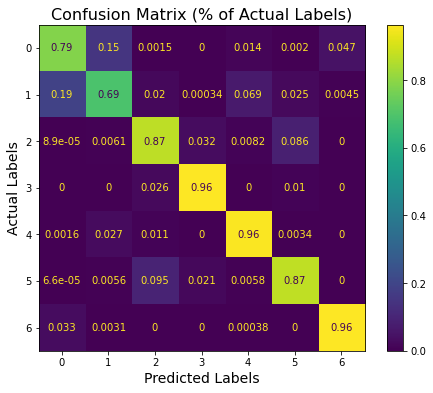

In [7]:
test_score, oof_preds, holdout = train_original(adaboost_pipeline)

metrics.append((
    'AdaBoost', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 2. ExtraTrees

In [8]:
# ExtraTrees Classifier
extratrees_pipeline = make_pipeline(
    ExtraTreesClassifier(
        n_jobs = -1,
        random_state = RANDOM_SEED,
        max_features = None,
    ),
)

Fold 0 Accuracy: 0.89286 in 2.95s.
Fold 1 Accuracy: 0.87619 in 2.98s.
Fold 2 Accuracy: 0.88571 in 3.01s.
Fold 3 Accuracy: 0.8873 in 3.03s.
Fold 4 Accuracy: 0.88651 in 3.06s.
Fold 5 Accuracy: 0.8873 in 3.13s.
Fold 6 Accuracy: 0.88333 in 2.96s.
Fold 7 Accuracy: 0.8746 in 2.96s.
Fold 8 Accuracy: 0.86349 in 3.04s.
Fold 9 Accuracy: 0.89365 in 3.04s.
Fold 10 Accuracy: 0.88175 in 2.96s.
Fold 11 Accuracy: 0.90627 in 2.97s.

Average CV Accuracy: 0.88491
Worst CV Accuracy: 0.86349
Holdout Accuracy: 0.77808
Training Time: 36.1s



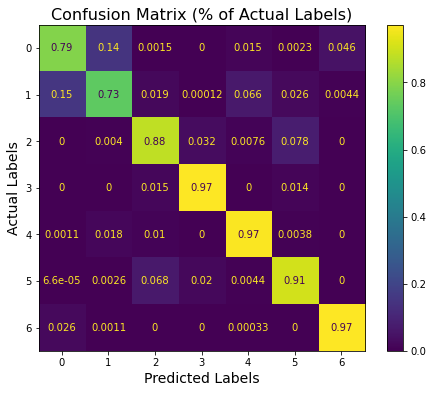

In [9]:
test_score, oof_preds, holdout = train_original(extratrees_pipeline)

metrics.append((
    'ExtraTrees', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 3. BaggingClassifier

In [10]:
# Bagging Classifier
bagging_pipeline = make_pipeline(
    BaggingClassifier(
        base_estimator = DecisionTreeClassifier(
            splitter = 'random',
            random_state = RANDOM_SEED,
        ),
        n_jobs = -1,
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.8627 in 2.93s.
Fold 1 Accuracy: 0.86111 in 1.73s.
Fold 2 Accuracy: 0.86429 in 1.78s.
Fold 3 Accuracy: 0.85159 in 1.76s.
Fold 4 Accuracy: 0.84762 in 1.74s.
Fold 5 Accuracy: 0.85238 in 1.74s.
Fold 6 Accuracy: 0.84524 in 1.74s.
Fold 7 Accuracy: 0.84841 in 2.21s.
Fold 8 Accuracy: 0.84762 in 1.92s.
Fold 9 Accuracy: 0.86825 in 1.97s.
Fold 10 Accuracy: 0.85 in 1.78s.
Fold 11 Accuracy: 0.87053 in 1.79s.

Average CV Accuracy: 0.85581
Worst CV Accuracy: 0.84524
Holdout Accuracy: 0.75372
Training Time: 23.08s



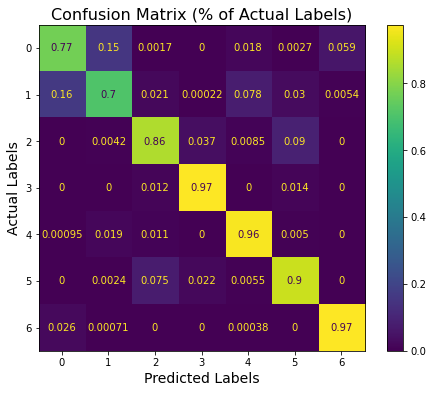

In [11]:
test_score, oof_preds, holdout = train_original(bagging_pipeline)

metrics.append((
    'Bagging', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 4. RandomForest

In [12]:
# Random Forest Classifier
randomforest_pipeline = make_pipeline(
    RandomForestClassifier(
        n_jobs = -1,
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.87381 in 2.82s.
Fold 1 Accuracy: 0.86429 in 2.77s.
Fold 2 Accuracy: 0.86032 in 3.11s.
Fold 3 Accuracy: 0.8627 in 2.71s.
Fold 4 Accuracy: 0.87222 in 3.45s.
Fold 5 Accuracy: 0.86032 in 2.91s.
Fold 6 Accuracy: 0.86349 in 2.68s.
Fold 7 Accuracy: 0.85317 in 2.64s.
Fold 8 Accuracy: 0.85397 in 2.65s.
Fold 9 Accuracy: 0.87222 in 2.68s.
Fold 10 Accuracy: 0.85714 in 2.65s.
Fold 11 Accuracy: 0.87371 in 2.79s.

Average CV Accuracy: 0.86395
Worst CV Accuracy: 0.85317
Holdout Accuracy: 0.74895
Training Time: 33.86s



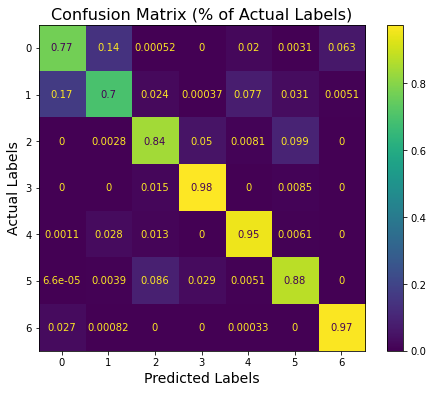

In [13]:
test_score, oof_preds, holdout = train_original(randomforest_pipeline)

metrics.append((
    'RandomForest', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 5. GradientBoosting

In [14]:
# Gradient Boosting Classifier
gbc_pipeline = make_pipeline(
    GradientBoostingClassifier(
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.80556 in 24.57s.
Fold 1 Accuracy: 0.78095 in 23.81s.
Fold 2 Accuracy: 0.7881 in 23.38s.
Fold 3 Accuracy: 0.79444 in 24.21s.
Fold 4 Accuracy: 0.80397 in 23.93s.
Fold 5 Accuracy: 0.79444 in 23.36s.
Fold 6 Accuracy: 0.80397 in 23.83s.
Fold 7 Accuracy: 0.79048 in 23.04s.
Fold 8 Accuracy: 0.78492 in 23.21s.
Fold 9 Accuracy: 0.80079 in 23.23s.
Fold 10 Accuracy: 0.8127 in 23.59s.
Fold 11 Accuracy: 0.78634 in 23.31s.

Average CV Accuracy: 0.79555
Worst CV Accuracy: 0.78095
Holdout Accuracy: 0.65171
Training Time: 283.46s



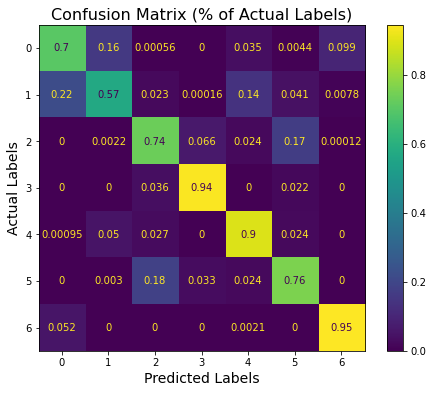

In [15]:
test_score, oof_preds, holdout = train_original(gbc_pipeline)

metrics.append((
    'GradientBoost', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 6. HistGradientBoosting

In [16]:
# Gradient Boosting Classifier
hgbc_pipeline = make_pipeline(
    HistGradientBoostingClassifier(
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.86349 in 10.98s.
Fold 1 Accuracy: 0.85873 in 11.63s.
Fold 2 Accuracy: 0.85 in 11.53s.
Fold 3 Accuracy: 0.85159 in 11.59s.
Fold 4 Accuracy: 0.86587 in 11.6s.
Fold 5 Accuracy: 0.85238 in 11.55s.
Fold 6 Accuracy: 0.8619 in 11.49s.
Fold 7 Accuracy: 0.84921 in 11.68s.
Fold 8 Accuracy: 0.85635 in 11.69s.
Fold 9 Accuracy: 0.86111 in 11.67s.
Fold 10 Accuracy: 0.85397 in 12.0s.
Fold 11 Accuracy: 0.86894 in 11.54s.

Average CV Accuracy: 0.8578
Worst CV Accuracy: 0.84921
Holdout Accuracy: 0.73949
Training Time: 138.95s



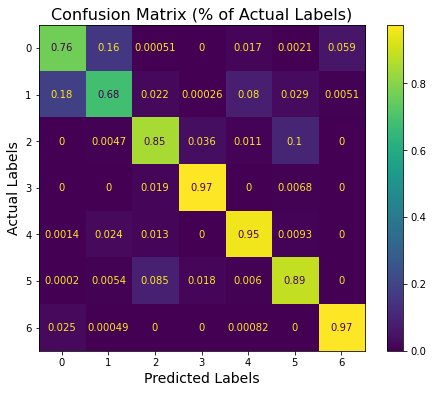

In [17]:
test_score, oof_preds, holdout = train_original(hgbc_pipeline)

metrics.append((
    'HistGradientBoost', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# XGBoost

We test out several XGBoost models:

1. Vanilla
2. Random Forest
3. DART

## 1. XGBoost Baseline

In [18]:
# XGBoost Classifier
xgb_pipeline = make_pipeline(
    XGBClassifier(
        booster = 'gbtree',
        tree_method = 'hist',
        eval_metric = 'mlogloss',
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.85556 in 2.06s.
Fold 1 Accuracy: 0.85556 in 2.12s.
Fold 2 Accuracy: 0.84524 in 2.12s.
Fold 3 Accuracy: 0.87063 in 2.12s.
Fold 4 Accuracy: 0.87143 in 2.12s.
Fold 5 Accuracy: 0.86349 in 2.12s.
Fold 6 Accuracy: 0.85952 in 2.27s.
Fold 7 Accuracy: 0.85714 in 2.16s.
Fold 8 Accuracy: 0.84762 in 2.35s.
Fold 9 Accuracy: 0.86429 in 2.64s.
Fold 10 Accuracy: 0.86508 in 2.21s.
Fold 11 Accuracy: 0.85544 in 2.35s.

Average CV Accuracy: 0.85925
Worst CV Accuracy: 0.84524
Holdout Accuracy: 0.74263
Training Time: 26.64s



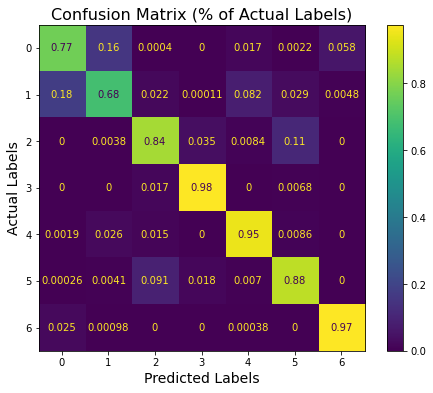

In [19]:
test_score, oof_preds, holdout = train_original(xgb_pipeline)

metrics.append((
    'XGBoost', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 2. XGBoost (Random Forest)

In [20]:
# XGBoost Classifier
xgbrf_pipeline = make_pipeline(
    XGBRFClassifier(
        tree_method = 'hist',
        eval_metric = 'mlogloss',
        num_parallel_tree = 100,
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.7619 in 2.5s.
Fold 1 Accuracy: 0.7246 in 2.5s.
Fold 2 Accuracy: 0.74841 in 2.5s.
Fold 3 Accuracy: 0.75397 in 2.51s.
Fold 4 Accuracy: 0.76587 in 2.55s.
Fold 5 Accuracy: 0.75 in 2.51s.
Fold 6 Accuracy: 0.7619 in 2.5s.
Fold 7 Accuracy: 0.75159 in 2.58s.
Fold 8 Accuracy: 0.75317 in 2.5s.
Fold 9 Accuracy: 0.75794 in 2.5s.
Fold 10 Accuracy: 0.76746 in 2.54s.
Fold 11 Accuracy: 0.75377 in 2.51s.

Average CV Accuracy: 0.75422
Worst CV Accuracy: 0.7246
Holdout Accuracy: 0.56616
Training Time: 30.19s



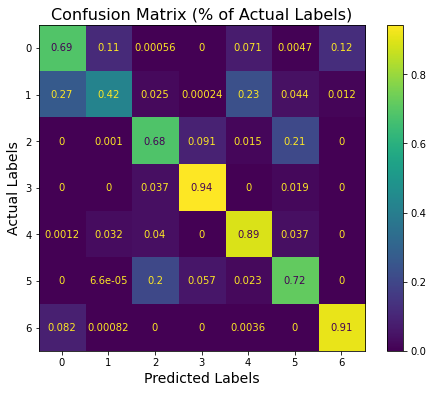

In [21]:
test_score, oof_preds, holdout = train_original(xgbrf_pipeline)

metrics.append((
    'XGBoost_RF', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 3. XGBoost (DART)

In [22]:
# XGBoost Classifier
xgbdart_pipeline = make_pipeline(
    XGBClassifier(
        booster = 'dart',
        tree_method = 'hist',
        eval_metric = 'mlogloss',
        rate_drop = 0.1,
        skip_drop = 0.5,
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.85 in 6.13s.
Fold 1 Accuracy: 0.83968 in 6.59s.
Fold 2 Accuracy: 0.82698 in 7.24s.
Fold 3 Accuracy: 0.85556 in 7.62s.
Fold 4 Accuracy: 0.84444 in 6.75s.
Fold 5 Accuracy: 0.84444 in 6.15s.
Fold 6 Accuracy: 0.84524 in 6.24s.
Fold 7 Accuracy: 0.83968 in 6.19s.
Fold 8 Accuracy: 0.82778 in 6.19s.
Fold 9 Accuracy: 0.84365 in 6.13s.
Fold 10 Accuracy: 0.84841 in 6.22s.
Fold 11 Accuracy: 0.8467 in 6.11s.

Average CV Accuracy: 0.84271
Worst CV Accuracy: 0.82698
Holdout Accuracy: 0.71109
Training Time: 77.56s



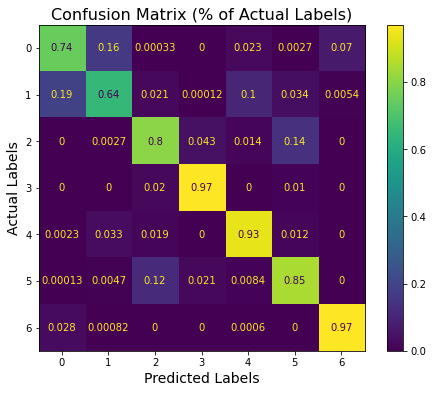

In [23]:
test_score, oof_preds, holdout = train_original(xgbdart_pipeline)

metrics.append((
    'XGBoost_DART', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# LightGBM

1. Vanilla
2. Random Forest
3. DART
4. GOSS

## 1. LightGBM (Baseline)

In [24]:
# LightGBM Classifier
lgbm_pipeline = make_pipeline(
    LGBMClassifier(
        boosting_type = 'gbdt',
        metric = 'multi_logloss',
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.86984 in 3.08s.
Fold 1 Accuracy: 0.86429 in 3.05s.
Fold 2 Accuracy: 0.85159 in 3.11s.
Fold 3 Accuracy: 0.85397 in 3.13s.
Fold 4 Accuracy: 0.86587 in 3.12s.
Fold 5 Accuracy: 0.85317 in 3.16s.
Fold 6 Accuracy: 0.87063 in 3.13s.
Fold 7 Accuracy: 0.8619 in 3.18s.
Fold 8 Accuracy: 0.85873 in 3.14s.
Fold 9 Accuracy: 0.87302 in 3.14s.
Fold 10 Accuracy: 0.85873 in 3.13s.
Fold 11 Accuracy: 0.86894 in 3.05s.

Average CV Accuracy: 0.86256
Worst CV Accuracy: 0.85159
Holdout Accuracy: 0.73671
Training Time: 37.44s



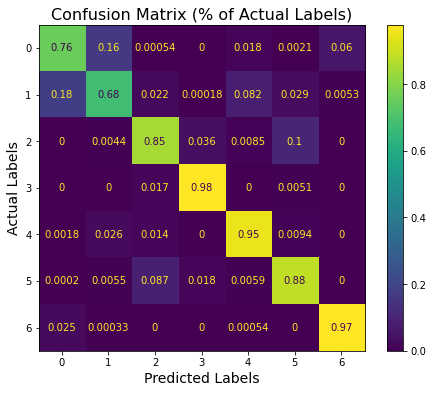

In [25]:
test_score, oof_preds, holdout = train_original(lgbm_pipeline)

metrics.append((
    'LightGBM', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 2. LightGBM (Random Forest)

In [26]:
# LightGBM Classifier
lgbm_pipeline = make_pipeline(
    LGBMClassifier(
        boosting_type = 'rf',
        metric = 'multi_logloss',
        colsample_bynode = 0.8,
        subsample = 0.8,
        subsample_freq = 1,
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.78571 in 3.09s.
Fold 1 Accuracy: 0.74683 in 3.03s.
Fold 2 Accuracy: 0.76508 in 2.95s.
Fold 3 Accuracy: 0.76905 in 2.96s.
Fold 4 Accuracy: 0.78651 in 2.95s.
Fold 5 Accuracy: 0.76587 in 2.94s.
Fold 6 Accuracy: 0.77857 in 2.93s.
Fold 7 Accuracy: 0.76905 in 2.96s.
Fold 8 Accuracy: 0.76905 in 2.99s.
Fold 9 Accuracy: 0.77619 in 2.94s.
Fold 10 Accuracy: 0.79048 in 3.09s.
Fold 11 Accuracy: 0.7784 in 2.94s.

Average CV Accuracy: 0.7734
Worst CV Accuracy: 0.74683
Holdout Accuracy: 0.60958
Training Time: 35.78s



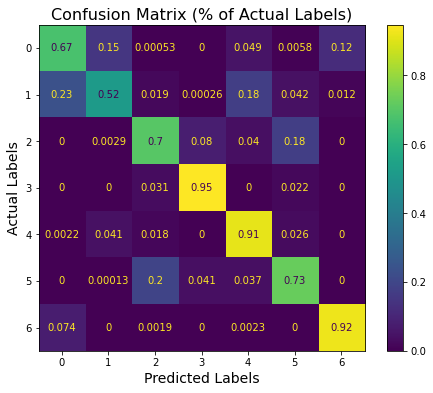

In [27]:
test_score, oof_preds, holdout = train_original(lgbm_pipeline)

metrics.append((
    'LightGBM_RF', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 3. LightGBM (DART)

In [28]:
# LightGBM Classifier
lgbm_pipeline = make_pipeline(
    LGBMClassifier(
        boosting_type = 'dart',
        metric = 'multi_logloss',
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.85397 in 3.23s.
Fold 1 Accuracy: 0.83413 in 3.21s.
Fold 2 Accuracy: 0.84524 in 3.27s.
Fold 3 Accuracy: 0.84365 in 3.31s.
Fold 4 Accuracy: 0.84762 in 3.24s.
Fold 5 Accuracy: 0.83968 in 3.24s.
Fold 6 Accuracy: 0.84921 in 3.41s.
Fold 7 Accuracy: 0.84048 in 3.23s.
Fold 8 Accuracy: 0.82778 in 3.29s.
Fold 9 Accuracy: 0.85556 in 3.5s.
Fold 10 Accuracy: 0.85 in 3.27s.
Fold 11 Accuracy: 0.85385 in 3.31s.

Average CV Accuracy: 0.8451
Worst CV Accuracy: 0.82778
Holdout Accuracy: 0.70277
Training Time: 39.51s



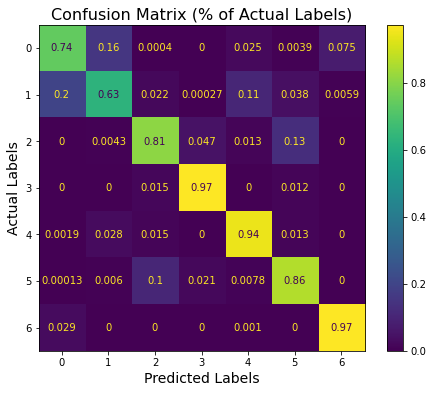

In [29]:
test_score, oof_preds, holdout = train_original(lgbm_pipeline)

metrics.append((
    'LightGBM_DART', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 4. LightGBM (GOSS)

In [30]:
# LightGBM Classifier
lgbm_pipeline = make_pipeline(
    LGBMClassifier(
        boosting_type = 'goss',
        metric = 'multi_logloss',
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.85476 in 3.56s.
Fold 1 Accuracy: 0.85873 in 3.66s.
Fold 2 Accuracy: 0.85079 in 3.57s.
Fold 3 Accuracy: 0.85794 in 3.5s.
Fold 4 Accuracy: 0.86825 in 3.43s.
Fold 5 Accuracy: 0.85079 in 3.49s.
Fold 6 Accuracy: 0.86429 in 3.51s.
Fold 7 Accuracy: 0.85 in 3.52s.
Fold 8 Accuracy: 0.85476 in 3.61s.
Fold 9 Accuracy: 0.86667 in 3.51s.
Fold 10 Accuracy: 0.85635 in 3.53s.
Fold 11 Accuracy: 0.86021 in 3.54s.

Average CV Accuracy: 0.85779
Worst CV Accuracy: 0.85
Holdout Accuracy: 0.73964
Training Time: 42.45s



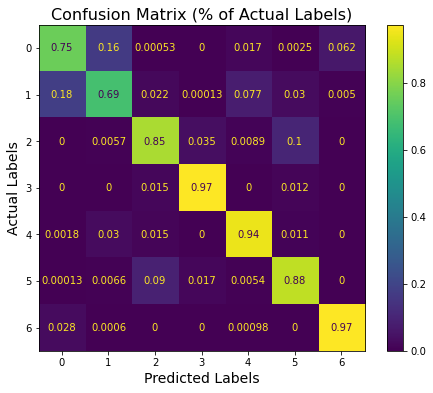

In [31]:
test_score, oof_preds, holdout = train_original(lgbm_pipeline)

metrics.append((
    'LightGBM_GOSS', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# CatBoost

In [32]:
# LightGBM Classifier
catboost_pipeline = make_pipeline(
    CatBoostClassifier(
        eval_metric = 'MultiClass',
        verbose = False,
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.86984 in 9.9s.
Fold 1 Accuracy: 0.85476 in 9.54s.
Fold 2 Accuracy: 0.85635 in 9.48s.
Fold 3 Accuracy: 0.8619 in 9.49s.
Fold 4 Accuracy: 0.87063 in 9.56s.
Fold 5 Accuracy: 0.85635 in 9.53s.
Fold 6 Accuracy: 0.86587 in 9.64s.
Fold 7 Accuracy: 0.85238 in 9.54s.
Fold 8 Accuracy: 0.83413 in 9.48s.
Fold 9 Accuracy: 0.86587 in 9.48s.
Fold 10 Accuracy: 0.85714 in 9.67s.
Fold 11 Accuracy: 0.86736 in 9.35s.

Average CV Accuracy: 0.85938
Worst CV Accuracy: 0.83413
Holdout Accuracy: 0.73901
Training Time: 114.66s



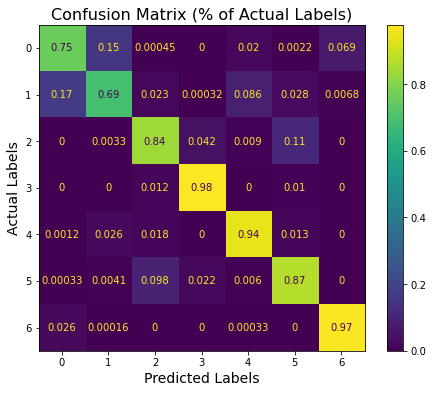

In [33]:
test_score, oof_preds, holdout = train_original(catboost_pipeline)

metrics.append((
    'CatBoost', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# Summary

In [34]:
pd.DataFrame.from_records(
    data = metrics,
    columns = ['model','accuracy','holdout','recall_0','recall_1','recall_2','recall_3','recall_4','recall_5','recall_6']
).sort_values('holdout')

,model,accuracy,holdout,recall_0,recall_1,recall_2,recall_3,recall_4,recall_5,recall_6
7,XGBoost_RF,0.754217,0.566156,0.688206,0.420984,0.684447,0.943782,0.890086,0.715920,0.913515
10,LightGBM_RF,0.773398,0.609576,0.674227,0.515176,0.700819,0.947189,0.912451,0.726508,0.921362
4,GradientBoost,0.795555,0.651708,0.704793,0.570162,0.735109,0.942078,0.897723,0.758401,0.945777
11,LightGBM_DART,0.845096,0.702767,0.740214,0.629318,0.808751,0.972743,0.943134,0.861577,0.969864
8,XGBoost_DART,0.842715,0.711090,0.744687,0.644449,0.802203,0.969336,0.934815,0.847965,0.970300
9,LightGBM,0.862557,0.736708,0.758556,0.677788,0.846674,0.977853,0.949270,0.882949,0.974605
13,CatBoost,0.859383,0.739009,0.754469,0.687580,0.837357,0.977853,0.941225,0.869731,0.973460
5,HistGradientBoost,0.857796,0.739490,0.761847,0.680662,0.848013,0.974446,0.951998,0.885119,0.973515
12,LightGBM_GOSS,0.857795,0.739636,0.754183,0.687057,0.850186,0.972743,0.942588,0.880976,0.970899
6,XGBoost,0.859250,0.742633,0.766425,0.684553,0.843280,0.976150,0.948725,0.879266,0.973297
